<font size=6 color='purple'>**Separation plots**</font>

*Notes:* Initialization cells must be run before plotting, since they define functions, colors, and snapshot numbers


In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gd
from utils.paths import SetupPaths
from utils.get_summary_data import compile_summary
from vectorCorrection import vectorCorrection as vector


paths = SetupPaths()

In [66]:
plt.rcParams.update({'font.size':20})
plt.rcParams.update({'font.size':20})

# Initialization

In [4]:
# defining equivalent redshifts
zs = {"z":np.array([0,1,2,3,4]), 
      "zill":np.array([135,85,68,60,56]), 
      "ztng":np.array([99,50,33,25,22])}

In [5]:
# defining color palette for plotting
palette = {"Illustris dark": "#009292", "Illustris hydro": "#B6DAFF",
           "TNG dark": "#930200", "TNG hydro": "#FFB5DC"}


In [6]:
# make functions to get data at the requested snapshot
def get_primmask(primstells, size):
    if size == "dwarf":
        mask = (primstells > 0.01) & (primstells < 0.5)
    elif size == "massive":
        mask = (primstells > 0.5) & (primstells < 10)
    return mask

def get_groupmask(groupmass, size):
    if size == "dwarf":
        mask = (groupmass > 8) & (groupmass < 50)
    elif size == "massive":
        mask = (groupmass > 100) & (groupmass < 650)
    return mask

def get_sepmask(seps, key="default", **kwargs):
    """Note: key can be
    'high' -- sep > 100
    'low'  -- 10 < sep < 80
    'default' -- sep > 10
    'spec' -- specify the lower and upper bound with kwargs
    ---
    kwargs: **{"min": lower bound, "max": upper bound}
    """
    seps = np.array(seps)
    minn = kwargs.pop("min",10)
    maxx = kwargs.pop("max",1000)
    
    if key == "high":
        mask = seps > 100
    elif key == "low":
        mask = (seps > 10) & (seps < 80)
    elif key == "default":
        mask = seps > 10
    elif key == "spec":
        mask = (seps > minn) & (seps < maxx)
    return mask

In [201]:
class EmptyFile(Exception): pass
class SkipRedshift(Exception): pass

def get_seps(sim, phys, size, sepmask="default", minn=10, maxx=1000, groupCut=False, median=False, errorprint=False, redshiftcutoff=True):    
    if sim == "Illustris":
        snapshots = np.arange(0,136,1)
        snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
        redcutoff = 3.8
    elif sim == "TNG":
        snapshots = np.arange(0,100,1)
        snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
        redcutoff = 4
        
    redshifts = []  
    med_pairs, med_major, med_minor = [], [], []
    quart_pairs, quart_major, quart_minor = [], [], []
            
    for snap in snapshots:  
        try:
            pair_path = f"{sim}_{snap}_10.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['pairs'][phys]['Group ID']) == 0):    
                raise EmptyFile
                
                

            # grabbing the relevant values
            pairs = pair_data["pairs"][phys]

            pri_stell = np.array(pairs["Sub1 Stellar Mass"])
            sec_stell = np.array(pairs["Sub2 Stellar Mass"])
            seps = np.array(pairs["Separation"]) 
            
            # masks            
            paired_prims = get_primmask(pri_stell, size)
            paired_group = get_groupmask(np.array(pairs["Group Mass"]), size)
            paired_median = np.array( pairs['Realization'] )==-1
            paired_sepcut = get_sepmask(seps, key=sepmask, **{"min":minn,"max":maxx})

            majors = (sec_stell/pri_stell > 1/4)
            minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)
      
            paired_mask = paired_prims & paired_sepcut
        
            if groupCut:
                paired_mask = paired_mask & paired_group
        
            if median:
                paired_mask = paired_mask & paired_median

                major_mask = paired_mask & majors
                minor_mask = paired_mask & minors
                                
                med_pairs_snap = np.median(seps[paired_mask])
                med_major_snap = np.median(seps[major_mask])
                med_minor_snap = np.median(seps[minor_mask])
                quart_pairs_snap = [0,0]
                quart_major_snap = [0,0]
                quart_minor_snap = [0,0]
                                                      
            elif ~median: 
                paired_per_real = []
                major_per_real = []
                minor_per_real = []
                
                realizations = np.unique( np.array(pairs['Realization']) )
                
                for real in realizations:
                    paired_real = np.array( pairs['Realization'] ) == real
                    
                    paired_mask_real = paired_mask & paired_real
                    major_mask_real = paired_mask_real & majors
                    minor_mask_real = paired_mask_real & minors
                    
                    if np.count_nonzero(paired_mask_real) == 0:
                        pair_xx = 0
                        major_xx = 0
                        minor_xx = 0
                        
                    else: 
                        pair_xx = np.median(seps[paired_mask_real])
                        
                        if np.count_nonzero(major_mask_real) == 0:
                            major_xx = 0
                        else:
                            major_xx = np.median(seps[major_mask_real])
                            
                        if np.count_nonzero(minor_mask_real) == 0:
                            minor_xx = 0
                        else:
                            minor_xx = np.median(seps[minor_mask_real])
                        
                    paired_per_real.append( pair_xx )
                    major_per_real.append( major_xx )
                    minor_per_real.append( minor_xx )

                med_pairs_snap = np.median(paired_per_real)
                med_major_snap = np.median(major_per_real)
                med_minor_snap = np.median(minor_per_real)
                quart_pairs_snap = np.percentile( paired_per_real,[16,84] ) 
                quart_major_snap = np.percentile( major_per_real,[16,84] ) 
                quart_minor_snap = np.percentile( minor_per_real,[16,84] ) 
                
            redshifts.append( redshift )
            med_pairs.append( med_pairs_snap )
            med_major.append( med_major_snap )
            med_minor.append( med_minor_snap )


            quart_pairs.append( quart_pairs_snap )
            quart_major.append( quart_major_snap )
            quart_minor.append( quart_minor_snap )

        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
    sep_dictionary = {"z":np.array(redshifts),
                        "All Median": np.array(med_pairs),
                        "Major Median": np.array(med_major),
                        "Minor Median":np.array(med_minor),
                        "All Quarts":np.array(quart_pairs),
                        "Major Quarts":np.array(quart_major),
                        "Minor Quarts":np.array(quart_minor)}
    
    return sep_dictionary

def get_seps_simstars(sim, size, sepmask="default", minn=10, maxx=1000, groupCut=False, errorprint=False, redshiftcutoff=True, **kwargs):    
    if sim == "Illustris":
        snapshots = np.arange(0,136,1)
        snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
        redcutoff = 3.8
    elif sim == "TNG":
        snapshots = np.arange(0,100,1)
        snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
        redcutoff = 4
        
    redshifts = []  
    med_pairs, med_major, med_minor = [], [], []
    quart_pairs, quart_major, quart_minor = [], [], []
            
    for snap in snapshots:  
        try:
            pair_path = f"{sim}_{snap}_simstars.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['paired'][phys]['Group ID']) == 0):    
                raise EmptyFile
                
            # grabbing the relevant values
            pairs = pair_data["paired"][phys]

            pri_stell = np.array(pairs["Sub1 Stellar Mass"])
            sec_stell = np.array(pairs["Sub2 Stellar Mass"])
            seps = np.array(pairs["Separation"]) 
            
            # masks            
            paired_prims = get_primmask(pri_stell, size)
            paired_group = get_groupmask(np.array(pairs["Group Mass"]), size)
            paired_median = np.array( pairs['Realization'] )==-1
            paired_sepcut = get_sepmask(seps, sepmask, **{"min":minn,"max":maxx})

            majors = (sec_stell/pri_stell > 1/4)
            minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)
      
            paired_mask = paired_prims & paired_sepcut
        
            if groupCut:
                paired_mask = paired_mask & paired_group
        
            paired_mask = paired_mask & paired_median

            major_mask = paired_mask & majors
            minor_mask = paired_mask & minors

            med_pairs_snap = np.median(seps[paired_mask])
            med_major_snap = np.median(seps[major_mask])
            med_minor_snap = np.median(seps[minor_mask])
            quart_pairs_snap = [0,0]
            quart_major_snap = [0,0]
            quart_minor_snap = [0,0]
                                                      
            
            redshifts.append( redshift )
            med_pairs.append( med_pairs_snap )
            med_major.append( med_major_snap )
            med_minor.append( med_minor_snap )


            quart_pairs.append( quart_pairs_snap )
            quart_major.append( quart_major_snap )
            quart_minor.append( quart_minor_snap )

        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
    sep_dictionary = {"z":np.array(redshifts),
                        "All Median": np.array(med_pairs),
                        "Major Median": np.array(med_major),
                        "Minor Median":np.array(med_minor),
                        "All Quarts":np.array(quart_pairs),
                        "Major Quarts":np.array(quart_major),
                        "Minor Quarts":np.array(quart_minor)}
    
    return sep_dictionary


# Separations 

## Dwarf
### All Pairs

In [238]:
kwarg_dict = {"groupCut": True, 
              "median":False, 
              "errorprint":False, 
              "redshiftcutoff":True,
              "sepmask":"default"}

size = "dwarf"

illd = get_seps("Illustris", "dark", size, **kwarg_dict)
illh = get_seps("Illustris", "hydro", size, **kwarg_dict)

tngd = get_seps("TNG", "dark", size, **kwarg_dict)
tngh = get_seps("TNG", "hydro", size, **kwarg_dict)

illsim = get_seps_simstars("Illustris", size, **kwarg_dict)
tngsim = get_seps_simstars("TNG", size, **kwarg_dict)


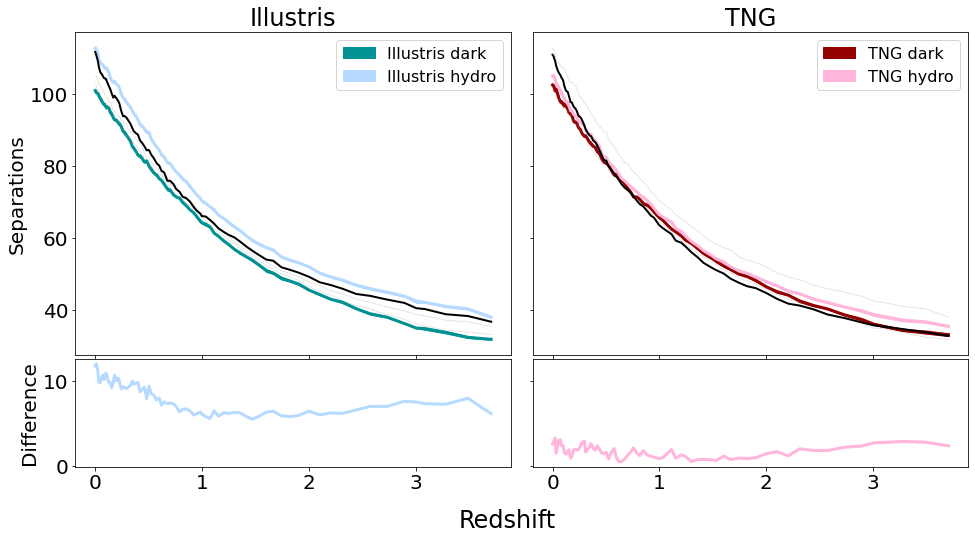

In [239]:
## plot of separations of all pairs
fig, ax = plt.subplots(2, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1],'wspace': 0.05,"hspace":0.02})

axILL = ax[0][0]
axTNG = ax[0][1]
axilldiff = ax[1][0]
axtngdiff = ax[1][1]

########################
# Illustris plot first #
########################
axILL.set(title="Illustris", ylabel="Separations")

axILL.plot(illd['z'],illd['All Median'], color=palette["Illustris dark"], lw=3)
axILL.plot(illh['z'],illh['All Median'], color=palette["Illustris hydro"], lw=3)

axILL.fill_between(illd['z'], np.array(illd['All Quarts'])[:,0], np.array(illd['All Quarts'])[:,1],color=palette["Illustris dark"],alpha=1, label="Illustris dark")
axILL.fill_between(illh['z'], np.array(illh['All Quarts'])[:,0], np.array(illh['All Quarts'])[:,1],color=palette["Illustris hydro"],alpha=1, label="Illustris hydro")

axILL.plot(tngd['z'],tngd['All Median'], color='grey',alpha=0.2, lw=1)
axILL.plot(tngh['z'],tngh["All Median"], color='grey',alpha=0.2, lw=1)

axILL.plot(illsim['z'],illsim['All Median'], color='black', lw=2)


############
# TNG plot #
############
axTNG.set(title="TNG")
axTNG.plot(tngd['z'],tngd['All Median'], color=palette["TNG dark"], lw=3)
axTNG.plot(tngh['z'],tngh['All Median'], color=palette["TNG hydro"], lw=3)

axTNG.fill_between(tngd['z'], np.array(tngd['All Quarts'])[:,0], np.array(tngd['All Quarts'])[:,1],color=palette["TNG dark"],alpha=1, label="TNG dark")
axTNG.fill_between(tngh['z'], np.array(tngh['All Quarts'])[:,0], np.array(tngh['All Quarts'])[:,1],color=palette["TNG hydro"],alpha=1, label="TNG hydro")

axTNG.plot(illd['z'],illd['All Median'], color='grey',alpha=0.2, lw=1)
axTNG.plot(illh['z'],illh['All Median'], color='grey',alpha=0.2, lw=1)

axTNG.plot(tngsim['z'],tngsim['All Median'], color='black', lw=2)


########################
# Illustris difference #
########################
axilldiff.set(ylabel=r"Difference")
axilldiff.plot(illd['z'], np.array(illh['All Median'])-np.array(illd['All Median']), color=palette["Illustris hydro"], lw=3)
# axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['unpaired'])-np.array(illh['unpaired']) )/np.array(illh['unpaired']), color=palette["Illustris hydro"], lw=2, linestyle='dotted')
# axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['paired'])-np.array(illh['paired']) )/np.array(illd['paired']), color=palette["Illustris dark"], lw=2, linestyle='dashed')


########################
# Illustris difference #
########################
axtngdiff.plot(tngd['z'], np.array(tngh['All Median'])-np.array(tngd['All Median']), color=palette["TNG hydro"], lw=3)
# axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['unpaired'])-np.array(tngh['unpaired']) )/np.array(tngh['unpaired']), color=palette["TNG hydro"], lw=2, linestyle='dotted')
# axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['paired'])-np.array(tngh['paired']) )/np.array(tngd['paired']), color=palette["TNG dark"], lw=2, linestyle='dashed')
# axtngdiff.set_ylim(0,23)

axILL.legend(loc="upper right",fontsize=16)
axTNG.legend(loc="upper right",fontsize=16)
fig.supxlabel("Redshift")
plt.savefig(f"../plots/separations/all_{kwarg_dict['sepmask']}_d.png",bbox_inches='tight',facecolor="white")
plt.show()


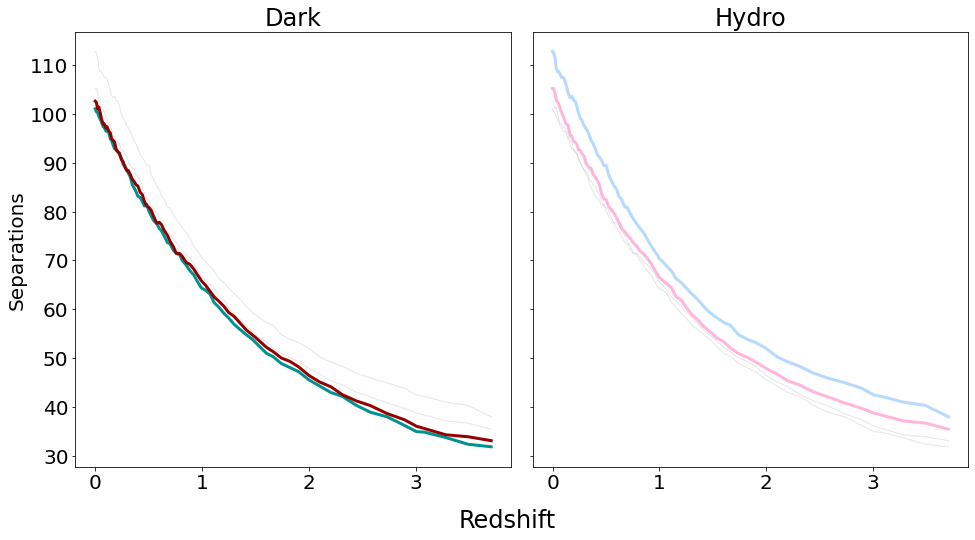

In [240]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(1, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1],'wspace': 0.05,"hspace":0.02})

axd = ax[0]
axh = ax[1]
# axddiff = ax[1][0]
# axhdiff = ax[1][1]

# illd, illh = Illustris['dark'], Illustris['hydro']
# tngd, tngh = TNG['dark'], TNG['hydro']

########################
# Illustris plot first #
########################
axd.set(title="Dark", ylabel="Separations")

axd.plot(illd['z'],illd['All Median'], color=palette["Illustris dark"], lw=3)
axd.plot(tngd['z'],tngd['All Median'], color=palette["TNG dark"], lw=3)

axd.plot(illh['z'],illh['All Median'], color='grey',alpha=0.2, lw=1)
axd.plot(tngh['z'],tngh["All Median"], color='grey',alpha=0.2, lw=1)


############
# TNG plot #
############
axh.set(title="Hydro")
axh.plot(illh['z'],illh['All Median'], color=palette["Illustris hydro"], lw=3)
axh.plot(tngh['z'],tngh['All Median'], color=palette["TNG hydro"], lw=3)

# axTNG.plot(tngd['z'],tngd['unpaired'], color=palette["TNG dark"], lw=2, linestyle="dotted")
# axTNG.plot(tngh['z'],tngh['unpaired'], color=palette["TNG hydro"], lw=2, linestyle="dotted")
# axTNG.plot(tngd['z'],tngd['paired'], color=palette["TNG dark"], lw=2, linestyle="dashed")
# axTNG.plot(tngh['z'],tngh['paired'], color=palette["TNG hydro"], lw=2, linestyle="dashed")

# axTNG.fill_between(tngd['z'], np.array(tngd['quartiles'])[:,0], np.array(tngd['quartiles'])[:,1],color=palette["TNG dark"],alpha=1, label="TNG dark")
# axTNG.fill_between(tngh['z'], np.array(tngh['quartiles'])[:,0], np.array(tngh['quartiles'])[:,1],color=palette["TNG hydro"],alpha=1, label="TNG hydro")

axh.plot(illd['z'],illd['All Median'], color='grey',alpha=0.2, lw=1)
axh.plot(tngd['z'],tngd['All Median'], color='grey',alpha=0.2, lw=1)

# axTNG.plot(simstars['TNG']['z'],simstars['TNG']['prims'], color='black', lw=3)
# axTNG.plot(simstars['TNG']['z'],simstars['TNG']['paired'], color='black',linestyle='dashed', lw=2,alpha=0.8)
# axTNG.plot(simstars['TNG']['z'],simstars['TNG']['unpaired'], color='black',linestyle='dotted', lw=2,alpha=0.8)


########################
# Illustris difference #
########################
# axddiff.set(ylabel=r"$\%$ Difference")
# axddiff.plot(illd['z'], 100*np.abs( np.array(illd['medians'])-np.array(illh['medians']) )/np.array(illh['medians']), color=palette["Illustris hydro"], lw=3)
# axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['unpaired'])-np.array(illh['unpaired']) )/np.array(illh['unpaired']), color=palette["Illustris hydro"], lw=2, linestyle='dotted')
# axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['paired'])-np.array(illh['paired']) )/np.array(illd['paired']), color=palette["Illustris dark"], lw=2, linestyle='dashed')


########################
# Illustris difference #
########################
# axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['medians'])-np.array(tngh['medians']) )/np.array(tngd['medians']), color=palette["TNG dark"], lw=3)
# axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['unpaired'])-np.array(tngh['unpaired']) )/np.array(tngh['unpaired']), color=palette["TNG hydro"], lw=2, linestyle='dotted')
# axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['paired'])-np.array(tngh['paired']) )/np.array(tngd['paired']), color=palette["TNG dark"], lw=2, linestyle='dashed')
# axtngdiff.set_ylim(0,23)

# axILL.legend(loc="upper right",fontsize=16)
# axTNG.legend(loc="upper right",fontsize=16)
fig.supxlabel("Redshift")
# plt.savefig(f"../plots/pairs_plots/counts_dwarfs.png",bbox_inches='tight',facecolor="white")
plt.show()


### Major vs. minor

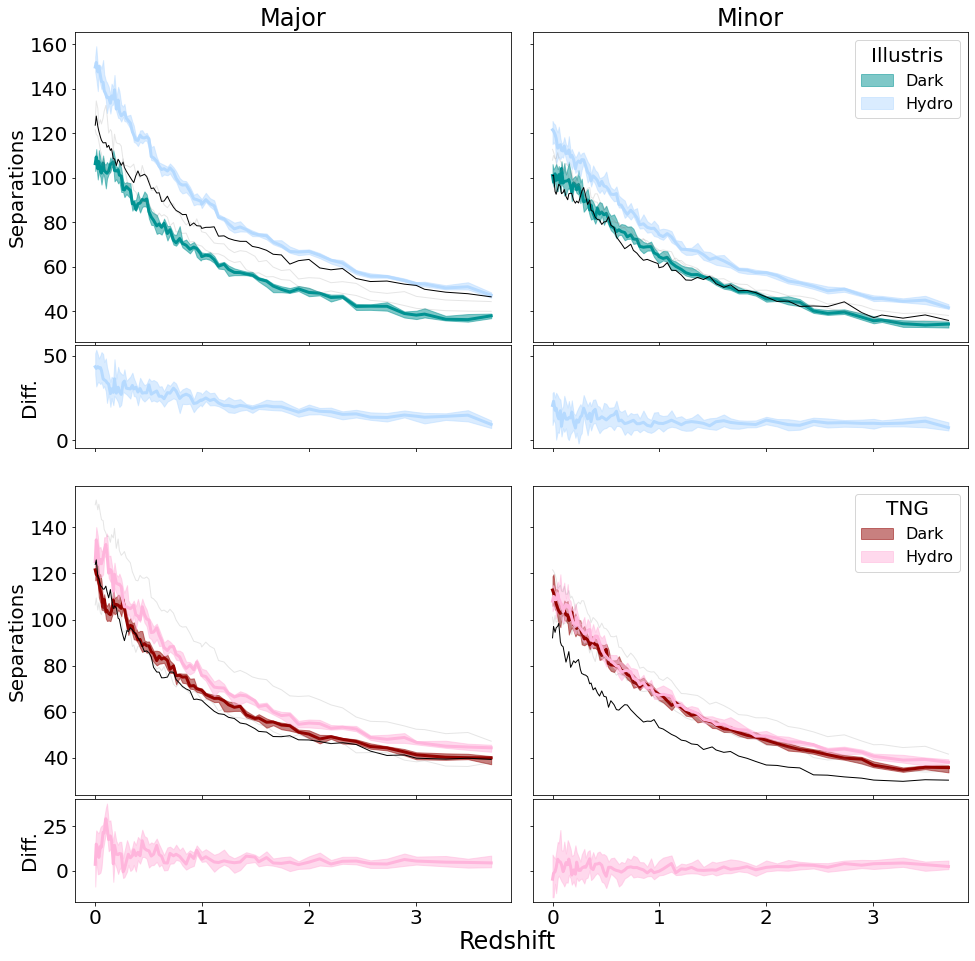

In [241]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.3,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]

axtngmaj = ax[3][0]
axtngmin = ax[3][1]

axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

al = 0.5

###################
# Illustris major #
###################
axillmaj.set(title="Major", ylabel="Separations")
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)
axillmaj.plot(illsim['z'],illsim['Major Median'], color='black', lw=1)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Major Median'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Major Median"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Major Quarts'])[:,0]-np.array(illd['Major Quarts'])[:,1]
highdiff = np.array(illh['Major Quarts'])[:,1]-np.array(illd['Major Quarts'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illh['Major Median'])-np.array(illd['Major Median']) ), color=palette["Illustris hydro"], lw=3)
axillmajdiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.set(title="Minor")
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)
axillmin.plot(illsim['z'],illsim['Minor Median'], color='black', lw=1)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Minor Median'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Minor Quarts'])[:,0]-np.array(illd['Minor Quarts'])[:,1]
highdiff = np.array(illh['Minor Quarts'])[:,1]-np.array(illd['Minor Quarts'])[:,0]
axillmindiff.plot(illd['z'], (np.array(illh['Minor Median'])-np.array(illd['Minor Median']) ), color=palette["Illustris hydro"], lw=3)
axillmindiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Hydro")


#############
# TNG major #
#############
axtngmaj.set(ylabel="Separations")
axtngmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Major Median'], color='black', lw=1)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Major Median'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Major Median"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngh['Major Quarts'])[:,0]-np.array(tngd['Major Quarts'])[:,1]
highdiff = np.array(tngh['Major Quarts'])[:,1]-np.array(tngd['Major Quarts'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngh['Major Median'])-np.array(tngd['Major Median']) ), color=palette["TNG hydro"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)
axtngmin.plot(tngsim['z'],tngsim['Minor Median'], color='black', lw=1)

axtngmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Minor Median'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngh['Minor Quarts'])[:,0]-np.array(tngd['Minor Quarts'])[:,1]
highdiff = np.array(tngh['Minor Quarts'])[:,1]-np.array(tngd['Minor Quarts'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngh['Minor Median'])-np.array(tngd['Minor Median']) ), color=palette["TNG hydro"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper right",fontsize=16)
axtngmin.legend(title="TNG",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/separations/majorminor_{kwarg_dict['sepmask']}_d.png",bbox_inches='tight',facecolor="white")
plt.show()


## Massive

In [242]:
kwarg_dict = {"groupCut": True, 
              "median":False, 
              "errorprint":False, 
              "redshiftcutoff":True,
              "sepmask":"default"}

size = "massive"

illd = get_seps("Illustris", "dark", size, **kwarg_dict)
illh = get_seps("Illustris", "hydro", size, **kwarg_dict)

tngd = get_seps("TNG", "dark", size, **kwarg_dict)
tngh = get_seps("TNG", "hydro", size, **kwarg_dict)

illsim = get_seps_simstars("Illustris", size, **kwarg_dict)
tngsim = get_seps_simstars("TNG", size, **kwarg_dict)


### All pairs

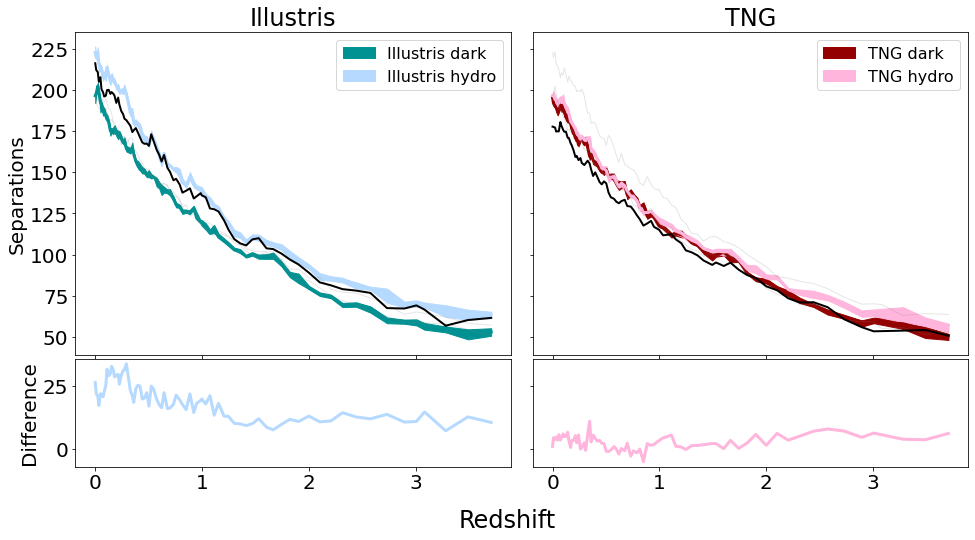

In [243]:
## plot of separations of all pairs
fig, ax = plt.subplots(2, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1],'wspace': 0.05,"hspace":0.02})

axILL = ax[0][0]
axTNG = ax[0][1]
axilldiff = ax[1][0]
axtngdiff = ax[1][1]

########################
# Illustris plot first #
########################
axILL.set(title="Illustris", ylabel="Separations")

axILL.plot(illd['z'],illd['All Median'], color=palette["Illustris dark"], lw=3)
axILL.plot(illh['z'],illh['All Median'], color=palette["Illustris hydro"], lw=3)

axILL.fill_between(illd['z'], np.array(illd['All Quarts'])[:,0], np.array(illd['All Quarts'])[:,1],color=palette["Illustris dark"],alpha=1, label="Illustris dark")
axILL.fill_between(illh['z'], np.array(illh['All Quarts'])[:,0], np.array(illh['All Quarts'])[:,1],color=palette["Illustris hydro"],alpha=1, label="Illustris hydro")

axILL.plot(tngd['z'],tngd['All Median'], color='grey',alpha=0.2, lw=1)
axILL.plot(tngh['z'],tngh["All Median"], color='grey',alpha=0.2, lw=1)

axILL.plot(illsim['z'],illsim['All Median'], color='black', lw=2)


############
# TNG plot #
############
axTNG.set(title="TNG")
axTNG.plot(tngd['z'],tngd['All Median'], color=palette["TNG dark"], lw=3)
axTNG.plot(tngh['z'],tngh['All Median'], color=palette["TNG hydro"], lw=3)

axTNG.fill_between(tngd['z'], np.array(tngd['All Quarts'])[:,0], np.array(tngd['All Quarts'])[:,1],color=palette["TNG dark"],alpha=1, label="TNG dark")
axTNG.fill_between(tngh['z'], np.array(tngh['All Quarts'])[:,0], np.array(tngh['All Quarts'])[:,1],color=palette["TNG hydro"],alpha=1, label="TNG hydro")

axTNG.plot(illd['z'],illd['All Median'], color='grey',alpha=0.2, lw=1)
axTNG.plot(illh['z'],illh['All Median'], color='grey',alpha=0.2, lw=1)

axTNG.plot(tngsim['z'],tngsim['All Median'], color='black', lw=2)


########################
# Illustris difference #
########################
axilldiff.set(ylabel=r"Difference")
axilldiff.plot(illd['z'], np.array(illh['All Median'])-np.array(illd['All Median']), color=palette["Illustris hydro"], lw=3)
# axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['unpaired'])-np.array(illh['unpaired']) )/np.array(illh['unpaired']), color=palette["Illustris hydro"], lw=2, linestyle='dotted')
# axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['paired'])-np.array(illh['paired']) )/np.array(illd['paired']), color=palette["Illustris dark"], lw=2, linestyle='dashed')


########################
# Illustris difference #
########################
axtngdiff.plot(tngd['z'], np.array(tngh['All Median'])-np.array(tngd['All Median']), color=palette["TNG hydro"], lw=3)
# axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['unpaired'])-np.array(tngh['unpaired']) )/np.array(tngh['unpaired']), color=palette["TNG hydro"], lw=2, linestyle='dotted')
# axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['paired'])-np.array(tngh['paired']) )/np.array(tngd['paired']), color=palette["TNG dark"], lw=2, linestyle='dashed')
# axtngdiff.set_ylim(0,23)

axILL.legend(loc="upper right",fontsize=16)
axTNG.legend(loc="upper right",fontsize=16)
fig.supxlabel("Redshift")
plt.savefig(f"../plots/separations/all_{kwarg_dict['sepmask']}_m.png",bbox_inches='tight',facecolor="white")
plt.show()


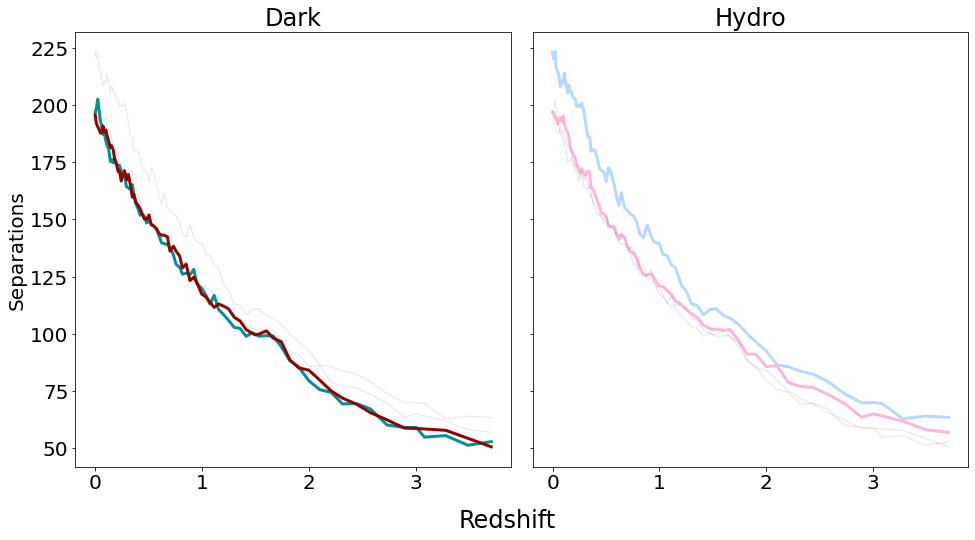

In [244]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(1, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1],'wspace': 0.05,"hspace":0.02})

axd = ax[0]
axh = ax[1]
# axddiff = ax[1][0]
# axhdiff = ax[1][1]

# illd, illh = Illustris['dark'], Illustris['hydro']
# tngd, tngh = TNG['dark'], TNG['hydro']

########################
# Illustris plot first #
########################
axd.set(title="Dark", ylabel="Separations")

axd.plot(illd['z'],illd['All Median'], color=palette["Illustris dark"], lw=3)
axd.plot(tngd['z'],tngd['All Median'], color=palette["TNG dark"], lw=3)

axd.plot(illh['z'],illh['All Median'], color='grey',alpha=0.2, lw=1)
axd.plot(tngh['z'],tngh["All Median"], color='grey',alpha=0.2, lw=1)


############
# TNG plot #
############
axh.set(title="Hydro")
axh.plot(illh['z'],illh['All Median'], color=palette["Illustris hydro"], lw=3)
axh.plot(tngh['z'],tngh['All Median'], color=palette["TNG hydro"], lw=3)

# axTNG.plot(tngd['z'],tngd['unpaired'], color=palette["TNG dark"], lw=2, linestyle="dotted")
# axTNG.plot(tngh['z'],tngh['unpaired'], color=palette["TNG hydro"], lw=2, linestyle="dotted")
# axTNG.plot(tngd['z'],tngd['paired'], color=palette["TNG dark"], lw=2, linestyle="dashed")
# axTNG.plot(tngh['z'],tngh['paired'], color=palette["TNG hydro"], lw=2, linestyle="dashed")

# axTNG.fill_between(tngd['z'], np.array(tngd['quartiles'])[:,0], np.array(tngd['quartiles'])[:,1],color=palette["TNG dark"],alpha=1, label="TNG dark")
# axTNG.fill_between(tngh['z'], np.array(tngh['quartiles'])[:,0], np.array(tngh['quartiles'])[:,1],color=palette["TNG hydro"],alpha=1, label="TNG hydro")

axh.plot(illd['z'],illd['All Median'], color='grey',alpha=0.2, lw=1)
axh.plot(tngd['z'],tngd['All Median'], color='grey',alpha=0.2, lw=1)

# axTNG.plot(simstars['TNG']['z'],simstars['TNG']['prims'], color='black', lw=3)
# axTNG.plot(simstars['TNG']['z'],simstars['TNG']['paired'], color='black',linestyle='dashed', lw=2,alpha=0.8)
# axTNG.plot(simstars['TNG']['z'],simstars['TNG']['unpaired'], color='black',linestyle='dotted', lw=2,alpha=0.8)


########################
# Illustris difference #
########################
# axddiff.set(ylabel=r"$\%$ Difference")
# axddiff.plot(illd['z'], 100*np.abs( np.array(illd['medians'])-np.array(illh['medians']) )/np.array(illh['medians']), color=palette["Illustris hydro"], lw=3)
# axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['unpaired'])-np.array(illh['unpaired']) )/np.array(illh['unpaired']), color=palette["Illustris hydro"], lw=2, linestyle='dotted')
# axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['paired'])-np.array(illh['paired']) )/np.array(illd['paired']), color=palette["Illustris dark"], lw=2, linestyle='dashed')


########################
# Illustris difference #
########################
# axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['medians'])-np.array(tngh['medians']) )/np.array(tngd['medians']), color=palette["TNG dark"], lw=3)
# axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['unpaired'])-np.array(tngh['unpaired']) )/np.array(tngh['unpaired']), color=palette["TNG hydro"], lw=2, linestyle='dotted')
# axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['paired'])-np.array(tngh['paired']) )/np.array(tngd['paired']), color=palette["TNG dark"], lw=2, linestyle='dashed')
# axtngdiff.set_ylim(0,23)

# axILL.legend(loc="upper right",fontsize=16)
# axTNG.legend(loc="upper right",fontsize=16)
fig.supxlabel("Redshift")
# plt.savefig(f"../plots/pairs_plots/counts_dwarfs.png",bbox_inches='tight',facecolor="white")
plt.show()


### Major vs. minor

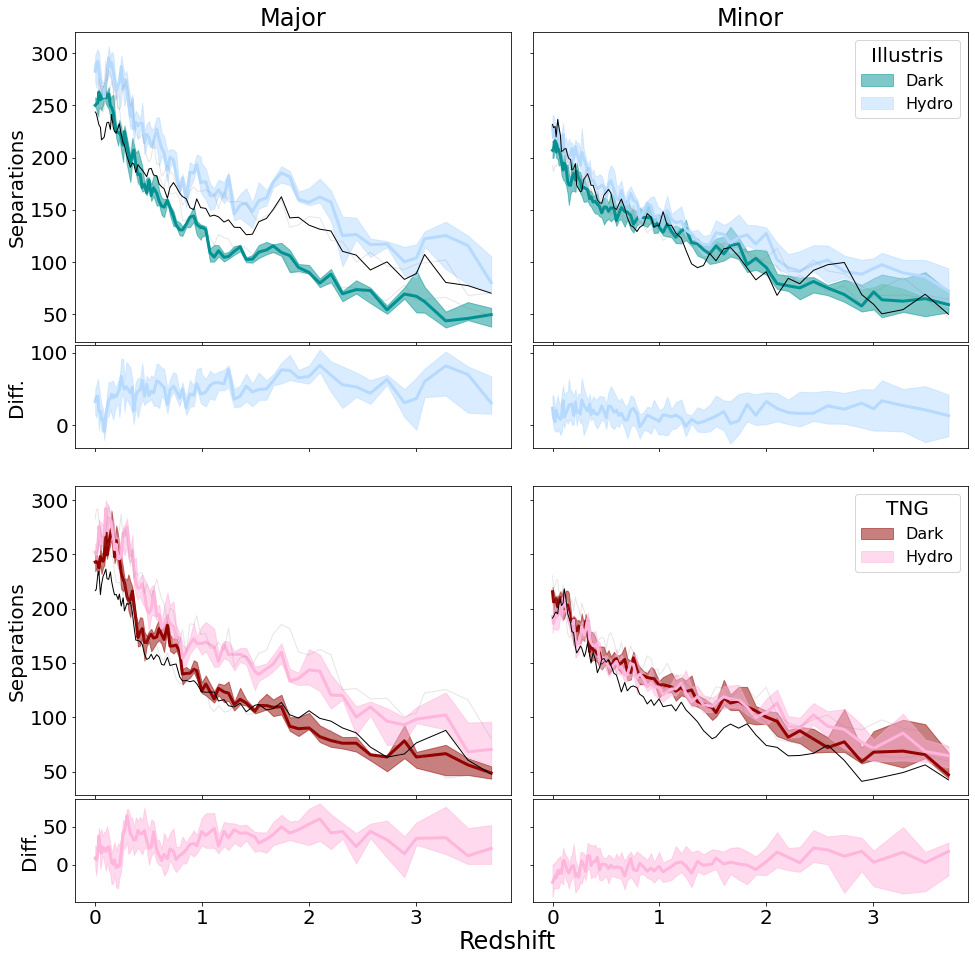

In [245]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.3,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]

axtngmaj = ax[3][0]
axtngmin = ax[3][1]

axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

al = 0.5

###################
# Illustris major #
###################
axillmaj.set(title="Major", ylabel="Separations")
axillmaj.plot(illd['z'],illd['Major Median'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Major Median'], color=palette["Illustris hydro"], lw=3)
axillmaj.plot(illsim['z'],illsim['Major Median'], color='black', lw=1)

axillmaj.fill_between(illd['z'], np.array(illd['Major Quarts'])[:,0], np.array(illd['Major Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Major Quarts'])[:,0], np.array(illh['Major Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Major Median'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Major Median"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Major Quarts'])[:,0]-np.array(illd['Major Quarts'])[:,1]
highdiff = np.array(illh['Major Quarts'])[:,1]-np.array(illd['Major Quarts'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illh['Major Median'])-np.array(illd['Major Median']) ), color=palette["Illustris hydro"], lw=3)
axillmajdiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.set(title="Minor")
axillmin.plot(illd['z'],illd['Minor Median'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Minor Median'], color=palette["Illustris hydro"], lw=3)
axillmin.plot(illsim['z'],illsim['Minor Median'], color='black', lw=1)

axillmin.fill_between(illd['z'], np.array(illd['Minor Quarts'])[:,0], np.array(illd['Minor Quarts'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Minor Quarts'])[:,0], np.array(illh['Minor Quarts'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Minor Median'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Minor Quarts'])[:,0]-np.array(illd['Minor Quarts'])[:,1]
highdiff = np.array(illh['Minor Quarts'])[:,1]-np.array(illd['Minor Quarts'])[:,0]
axillmindiff.plot(illd['z'], (np.array(illh['Minor Median'])-np.array(illd['Minor Median']) ), color=palette["Illustris hydro"], lw=3)
axillmindiff.fill_between(illd['z'], lowdiff, highdiff,color=palette["Illustris hydro"],alpha=al, label="Hydro")


#############
# TNG major #
#############
axtngmaj.set(ylabel="Separations")
axtngmaj.plot(tngd['z'],tngd['Major Median'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Major Median'], color=palette["TNG hydro"], lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Major Median'], color='black', lw=1)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Major Quarts'])[:,0], np.array(tngd['Major Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Major Quarts'])[:,0], np.array(tngh['Major Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Major Median'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Major Median"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngh['Major Quarts'])[:,0]-np.array(tngd['Major Quarts'])[:,1]
highdiff = np.array(tngh['Major Quarts'])[:,1]-np.array(tngd['Major Quarts'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngh['Major Median'])-np.array(tngd['Major Median']) ), color=palette["TNG hydro"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Minor Median'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Minor Median'], color=palette["TNG hydro"], lw=3)
axtngmin.plot(tngsim['z'],tngsim['Minor Median'], color='black', lw=1)

axtngmin.fill_between(tngd['z'], np.array(tngd['Minor Quarts'])[:,0], np.array(tngd['Minor Quarts'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Minor Quarts'])[:,0], np.array(tngh['Minor Quarts'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Minor Median'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Minor Median"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngh['Minor Quarts'])[:,0]-np.array(tngd['Minor Quarts'])[:,1]
highdiff = np.array(tngh['Minor Quarts'])[:,1]-np.array(tngd['Minor Quarts'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngh['Minor Median'])-np.array(tngd['Minor Median']) ), color=palette["TNG hydro"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG hydro"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper right",fontsize=16)
axtngmin.legend(title="TNG",loc="upper right",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/separations/majorminor_{kwarg_dict['sepmask']}_m.png",bbox_inches='tight',facecolor="white")
plt.show()


In [63]:
seps = get_seps("Illustris", "dark", "dwarf", sepmask="default")
    
# med = get_seps("Illustris", "dark", "dwarf", sepmask="default", median=True)

In [64]:
seps

{'z': array([3.70877426e+00, 3.49086137e+00, 3.28303306e+00, 3.08482264e+00,
        3.00813107e+00, 2.89578501e+00, 2.73314262e+00, 2.57729027e+00,
        2.44422570e+00, 2.31611074e+00, 2.20792547e+00, 2.10326965e+00,
        2.00202814e+00, 1.90408954e+00, 1.82268925e+00, 1.74357057e+00,
        1.66666956e+00, 1.60423452e+00, 1.53123903e+00, 1.47197485e+00,
        1.41409822e+00, 1.35757667e+00, 1.30237846e+00, 1.24847261e+00,
        1.20625808e+00, 1.15460271e+00, 1.11415056e+00, 1.07445789e+00,
        1.03551045e+00, 9.97294226e-01, 9.87852811e-01, 9.50531352e-01,
        9.23000816e-01, 8.86896938e-01, 8.51470901e-01, 8.16709979e-01,
        7.91068249e-01, 7.57441373e-01, 7.32636182e-01, 7.00106354e-01,
        6.76110411e-01, 6.44641841e-01, 6.21428745e-01, 5.98543288e-01,
        5.75980845e-01, 5.46392183e-01, 5.24565820e-01, 5.03047523e-01,
        4.81832943e-01, 4.60917794e-01, 4.40297849e-01, 4.19968942e-01,
        3.99926965e-01, 3.80167867e-01, 3.60687657e-01, 3.4

In [22]:
seps['medians']-med['medians']

array([1.56099901, 1.48851912, 1.49021873, 1.69728958, 1.65808802,
       1.90267248, 1.87699198, 1.60964797, 1.76314808, 1.68889775,
       1.81100041, 2.02775372, 1.72273091, 1.81875259, 1.95696354,
       2.0971168 , 1.99236261, 1.7361207 , 2.01636423, 2.2666252 ,
       2.04587546, 2.23578546, 2.01241965, 1.85565518, 1.97685341,
       1.94995457, 1.88938451, 1.99310113, 2.25114309, 1.94302933,
       2.25704612, 2.33498431, 2.20602393, 1.89339233, 1.78752582,
       1.53327182, 1.68950627, 1.35943714, 1.74471433, 1.51838304,
       1.59789639, 1.19940899, 1.39239536, 1.65321708, 1.458202  ,
       1.65707906, 1.51096442, 1.62125846, 1.75300566, 1.15286886,
       1.69535338, 1.94873665, 1.41131402, 1.44302044, 1.4225427 ,
       1.52249273, 1.73411903, 1.44072588, 1.51015977, 1.05128017,
       1.21431803, 0.92328443, 0.96789807, 1.21759394, 1.48453707,
       1.40913937, 1.65472999, 1.29118884, 1.52951503, 1.44189354,
       1.66463911, 1.346361  , 1.42230574, 0.75453808, 1.08679

In [54]:
pair_path = f"Illustris_135_10.hdf5"
pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")



# grabbing the relevant values
pairs = pair_data["pairs"][phys]

pri_stell = np.array(pairs["Sub1 Stellar Mass"])
sec_stell = np.array(pairs["Sub2 Stellar Mass"])
seps = np.array(pairs["Separation"]) 

In [55]:
# masks            
paired_prims = get_primmask(pri_stell, "dwarf")
paired_group = get_groupmask(np.array(pairs["Group Mass"]), size)
paired_median = np.array( pairs['Realization'] )==-1
paired_sepcut = get_sepmask(seps)

majors = (sec_stell/pri_stell > 1/4)
minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)

paired_mask = paired_prims & paired_sepcut

paired_mask = paired_mask & paired_group


In [57]:
pairs = pair_data["pairs"][phys]

pri_stell = np.array(pairs["Sub1 Stellar Mass"])
sec_stell = np.array(pairs["Sub2 Stellar Mass"])
seps = np.array(pairs["Separation"]) 

# masks            
paired_prims = get_primmask(pri_stell, size)
paired_group = get_groupmask(np.array(pairs["Group Mass"]), size)
paired_median = np.array( pairs['Realization'] )==-1
paired_sepcut = get_sepmask(seps)

majors = (sec_stell/pri_stell > 1/4)
minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)

paired_mask = paired_prims & paired_sepcut

In [58]:
paired_mask = paired_mask & paired_group

paired_per_real = []
major_per_real = []
minor_per_real = []

realizations = np.unique( np.array(pairs['Realization']) )

In [59]:
for real in realizations:
    paired_real = np.array( pairs['Realization'] ) == real

    paired_mask = paired_mask & paired_real
    major_mask = paired_mask & majors
    minor_mask = paired_mask & minors

    paired_per_real.append( np.median(seps[paired_mask]) )
    major_per_real.append( np.median(seps[major_mask]) )
    minor_per_real.append( np.median(seps[minor_mask]) )

med_pairs_snap = np.median(paired_per_real)
med_major_snap = np.median(major_per_real)
med_minor_snap = np.median(minor_per_real)
quart_pairs_snap = np.percentile( paired_per_real,[16,84] ) 
quart_major_snap = np.percentile( major_per_real,[16,84] ) 
quart_minor_snap = np.percentile( minor_per_real,[16,84] ) 

In [61]:
paired_per_real

[222.77418750119782, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [40]:
redshifts.append( redshift )
med_pairs.append( med_pairs_snap )
med_major.append( med_major_snap )
med_minor.append( med_minor_snap )


quart_pairs.append( quart_pairs_snap )
quart_major.append( quart_major_snap )
quart_minor.append( quart_minor_snap )

In [73]:
ill1 = get_seps("Illustris", "dark", "dwarf", groupCut=False)
ill2 = get_seps("Illustris", "dark", "dwarf", groupCut=True)
ill3 = get_seps("Illustris", "dark", "dwarf", **{"groupCut":True})

print(ill1['All Median']-ill2['All Median'])
print(ill1['All Median']-ill3['All Median'])
print(ill2['All Median']-ill3['All Median'])

[ 3.01384216e-01  3.69121239e-01  3.70746243e-01  4.26754641e-01
  5.46172525e-01  4.01579489e-01  5.51336088e-01  3.71006721e-01
  5.33626051e-01  5.15266250e-01  5.85837557e-01  5.39884220e-01
  5.27557840e-01  5.54491008e-01  5.95890201e-01  6.26495567e-01
  7.74550655e-01  6.40057556e-01  6.76454957e-01  7.66582003e-01
  6.49225670e-01  6.98844462e-01  7.38903392e-01  6.20000485e-01
  6.04446616e-01  5.65133065e-01  5.39317343e-01  5.45843824e-01
  6.14811751e-01  5.82932716e-01  6.04489639e-01  6.16551960e-01
  4.92018644e-01  3.53830854e-01  4.03520655e-01  4.33796700e-01
  3.41502631e-01  3.34947419e-01  4.05813503e-01  4.41149084e-01
  4.12126130e-01  3.87206712e-01  3.92958033e-01  2.97979909e-01
  2.49376058e-01  2.88723992e-01  3.61431668e-01  2.18667006e-01
  1.76458491e-01  2.39442629e-01  2.76041546e-01  2.95968000e-01
  2.44328009e-01  2.18003021e-01  1.20649854e-01  1.48003064e-01
  8.17895161e-02  6.46415210e-02  8.85876714e-02  9.97461524e-02
  1.10315983e-01  7.92927

In [71]:
ill1

{'z': array([3.70877426e+00, 3.49086137e+00, 3.28303306e+00, 3.08482264e+00,
        3.00813107e+00, 2.89578501e+00, 2.73314262e+00, 2.57729027e+00,
        2.44422570e+00, 2.31611074e+00, 2.20792547e+00, 2.10326965e+00,
        2.00202814e+00, 1.90408954e+00, 1.82268925e+00, 1.74357057e+00,
        1.66666956e+00, 1.60423452e+00, 1.53123903e+00, 1.47197485e+00,
        1.41409822e+00, 1.35757667e+00, 1.30237846e+00, 1.24847261e+00,
        1.20625808e+00, 1.15460271e+00, 1.11415056e+00, 1.07445789e+00,
        1.03551045e+00, 9.97294226e-01, 9.87852811e-01, 9.50531352e-01,
        9.23000816e-01, 8.86896938e-01, 8.51470901e-01, 8.16709979e-01,
        7.91068249e-01, 7.57441373e-01, 7.32636182e-01, 7.00106354e-01,
        6.76110411e-01, 6.44641841e-01, 6.21428745e-01, 5.98543288e-01,
        5.75980845e-01, 5.46392183e-01, 5.24565820e-01, 5.03047523e-01,
        4.81832943e-01, 4.60917794e-01, 4.40297849e-01, 4.19968942e-01,
        3.99926965e-01, 3.80167867e-01, 3.60687657e-01, 3.4

In [78]:
kwarg_dict = {"groupCut": True, 
              "median":False, 
              "errorprint":False, 
              "redshiftcutoff":False,
              "sepmask":"default"}

illd = get_seps("TNG", "dark", "dwarf", **kwarg_dict)
illh = get_seps("TNG", "hydro", "dwarf", **kwarg_dict)